In [31]:
"""
Advanced Analysis File (Revised)
This script extends your mid-term work by:
    - Merging multiple World Bank indicators along with renewable capacity and a policy indicator.
    - Setting up a panel dataset and cleaning it (using .loc and .copy() to avoid chained assignment warnings).
    - Running a two-way fixed effects panel regression (without an added constant) and a Random Effects model for comparison.
    - Performing a Hausman test comparison.
    - Producing both static and interactive visualizations.
"""

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from linearmodels import PanelOLS, RandomEffects
from linearmodels.panel import compare
import plotly.express as px

# -------------------------------
# Step 1: Helper Function to Melt Indicators
# -------------------------------
def melt_indicator(conn, series_name, start_year, end_year):
    """
    Extract wide-form data for a given World Bank indicator,
    then melt it into long format with columns: [country, year, value].
    """
    years = list(range(start_year, end_year + 1))
    # Build SELECT clause with year columns in the format: "YEAR [YRYEAR]"
    year_cols = ", ".join([f'w."{yr} [YR{yr}]" AS "{yr}"' for yr in years])
    query = f"""
    SELECT w.country, {year_cols}
    FROM world_bank w
    WHERE w.[Series Name] = '{series_name}'
    """
    df_wide = pd.read_sql_query(query, conn)
    # Melt the DataFrame to long format
    df_long = df_wide.melt(id_vars=["country"], var_name="year", value_name="value")
    df_long["year"] = df_long["year"].astype(int)
    df_long["value"] = pd.to_numeric(df_long["value"], errors="coerce")
    return df_long



In [32]:
# -------------------------------
# Step 2: Load and Merge Datasets
# -------------------------------
# Connect to the database
conn = sqlite3.connect("global_energy.db")

# Define the analysis period
start_year = 1970
end_year = 2020

# Melt World Bank indicators
df_energy = melt_indicator(conn, "Energy use (kg of oil equivalent per capita)", start_year, end_year)
df_gdp    = melt_indicator(conn, "GDP (current US$)", start_year, end_year)
df_fossil = melt_indicator(conn, "Fossil fuel energy consumption (% of total)", start_year, end_year)

# Merge energy and GDP data on (country, year)
df_panel = pd.merge(df_energy, df_gdp, on=["country", "year"], how="outer", suffixes=("_energy", "_gdp"))
# Merge in fossil fuel indicator; rename its 'value' column to fossil_share
df_panel = pd.merge(df_panel, df_fossil, on=["country", "year"], how="outer")
df_panel.rename(columns={"value": "fossil_share"}, inplace=True)

# Merge static renewable capacity data (from country_capacity)
df_capacity = pd.read_sql_query("SELECT * FROM country_capacity;", conn)
# Compute renewable ratio (assumed static per country)
df_capacity["renewable_ratio"] = df_capacity["total_renewable_capacity"] / df_capacity["total_capacity"]
df_panel = pd.merge(df_panel, df_capacity[["country", "renewable_ratio"]], on="country", how="left")

# Merge policy indicator from OECD green growth
# (Assuming the OECD table has a measure called 'ENV_TAX_REVENUE_%_of_GDP')
df_policy = pd.read_sql_query("""
SELECT 
    country,
    TIME_PERIOD AS year,
    OBS_VALUE AS env_tax
FROM oecd_greengrowth
WHERE MEASURE = 'ENV_TAX_REVENUE_%_of_GDP'
""", conn)
df_policy["year"] = pd.to_numeric(df_policy["year"], errors="coerce").astype("Int64")
df_panel = pd.merge(df_panel, df_policy, on=["country", "year"], how="left")

# Close the database connection
conn.close()



In [33]:
# -------------------------------
# Step 3: Data Cleaning and Preparation
# -------------------------------
# Drop rows with missing essential data and make an explicit copy
df_panel_clean = df_panel.dropna(subset=["value_energy", "value_gdp", "fossil_share", "renewable_ratio"]).copy()

# Use .loc for assignments to avoid SettingWithCopyWarning
df_panel_clean.loc[:, "energy_use"] = df_panel_clean["value_energy"]
df_panel_clean.loc[:, "gdp"] = df_panel_clean["value_gdp"]

df_panel_clean.loc[:, "year"] = df_panel_clean["year"].astype(int)

# For the policy variable, fill missing values with the median
df_panel_clean.loc[:, "env_tax"] = df_panel_clean["env_tax"].fillna(df_panel_clean["env_tax"].median())

# Ensure all exogenous columns are numeric
exog_vars = ["gdp", "fossil_share", "renewable_ratio", "env_tax"]
df_panel_clean[exog_vars] = df_panel_clean[exog_vars].apply(pd.to_numeric, errors="coerce")

# Set multi-index for panel data analysis and sort
df_panel_clean.set_index(["country", "year"], inplace=True)
df_panel_clean.sort_index(inplace=True)



/Users/shaokaiwen/anaconda3/envs/conda_usml_env/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/var/folders/_w/htmynbps67qc3xshbfqnl84h0000gp/T/ipykernel_95988/4091559588.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_panel_clean.loc[:, "env_tax"] = df_panel_clean["env_tax"].fillna(df_panel_clean["env_tax"].median())


In [39]:
# -------------------------------
# Step 4: Advanced Panel Regression Analysis
# -------------------------------
# For the Fixed Effects model, we drop 'renewable_ratio' (time invariant)
# and any exogenous columns that are constant overall.
exog_vars_fe = ["gdp", "fossil_share", "env_tax"]
exog_fe = df_panel_clean[exog_vars_fe].copy()
# Drop columns with no variation
exog_fe = exog_fe.loc[:, exog_fe.nunique() > 1]
print("Exogenous variables used in FE model:", exog_fe.columns.tolist())

# Run Two-way Fixed Effects (entity + time) model;
# use drop_absorbed=True to drop perfectly collinear variables.
model_fe = PanelOLS(
    df_panel_clean["energy_use"],
    exog_fe,
    entity_effects=True,
    time_effects=True,
    drop_absorbed=True,
    check_rank=False
)
res_fe = model_fe.fit(cov_type="clustered", cluster_entity=True)
print("=== Two-way Fixed Effects Model Results ===")
print(res_fe.summary)

# For the Random Effects model, include all variables and add a constant.
# We include 'renewable_ratio' here, but if it (or any column) is completely constant overall,
# we drop it to avoid the full rank error.
exog_re = sm.add_constant(df_panel_clean[["gdp", "fossil_share", "renewable_ratio", "env_tax"]])

# Check each column's standard deviation and drop if it is effectively constant.
for col in exog_re.columns:
    std_val = exog_re[col].std()
    if np.isnan(std_val) or np.isclose(std_val, 0):
        print(f"Dropping column '{col}' from RE model because its std is {std_val}")
        exog_re = exog_re.drop(columns=[col])

# Now run the Random Effects model with check_rank disabled.
model_re = RandomEffects(df_panel_clean["energy_use"], exog_re, check_rank=False)
res_re = model_re.fit()
print("\n=== Random Effects Model Results ===")
print(res_re.summary)

# Perform a Hausman test comparison using the compare function from linearmodels.panel.
comparison = compare({'FE': res_fe, 'RE': res_re})
print("\n=== Hausman Test Comparison ===")
print(comparison)

Exogenous variables used in FE model: ['gdp', 'fossil_share']
=== Two-way Fixed Effects Model Results ===
                          PanelOLS Estimation Summary                           
Dep. Variable:             energy_use   R-squared:                        0.0057
Estimator:                   PanelOLS   R-squared (Between):             -0.3263
No. Observations:                4523   R-squared (Within):              -0.0026
Date:                Mon, Mar 10 2025   R-squared (Overall):             -0.3100
Time:                        23:29:45   Log-likelihood                -3.686e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      12.554
Entities:                         125   P-value                           0.0000
Avg Obs:                       36.184   Distribution:                  F(2,4351)
Min Obs:                       4.0000                                           
Max

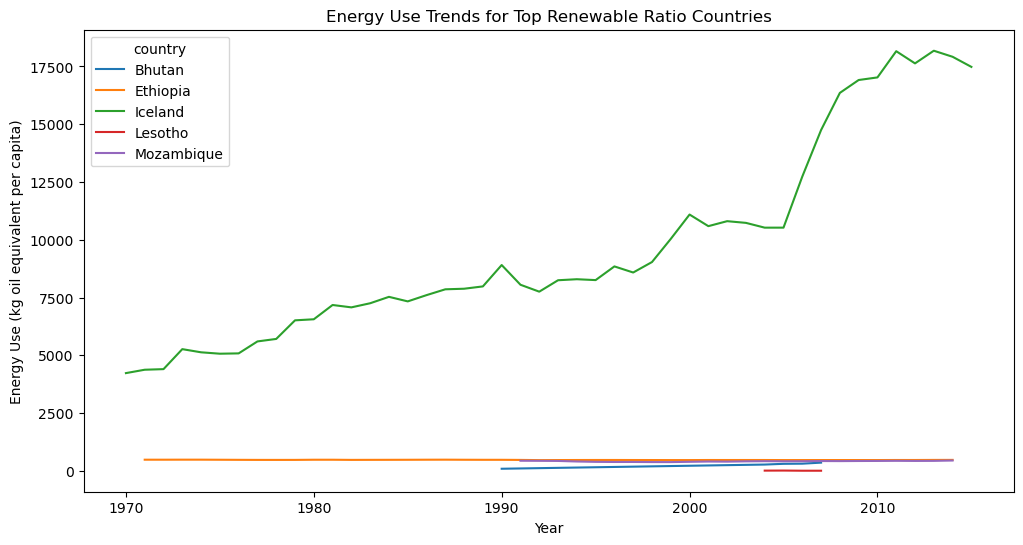

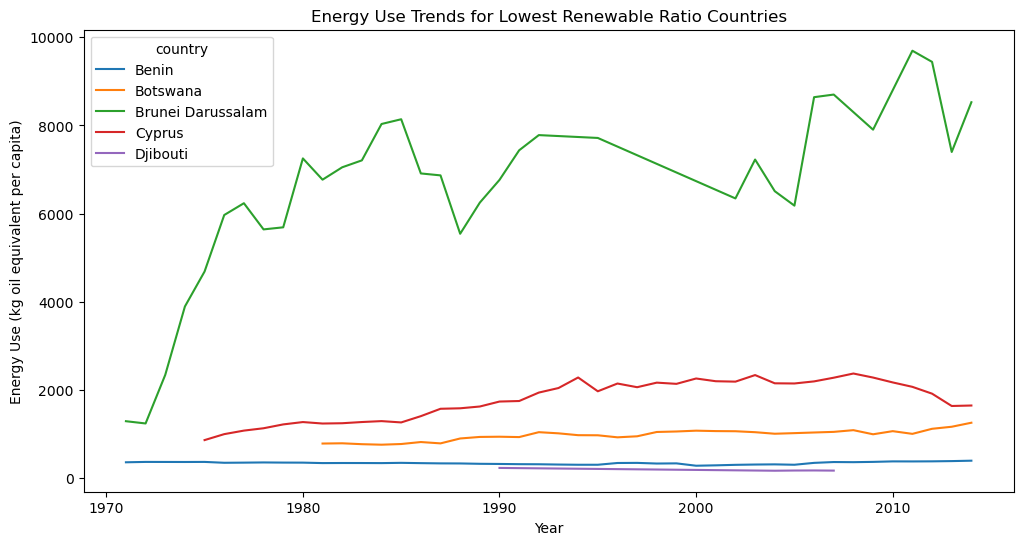

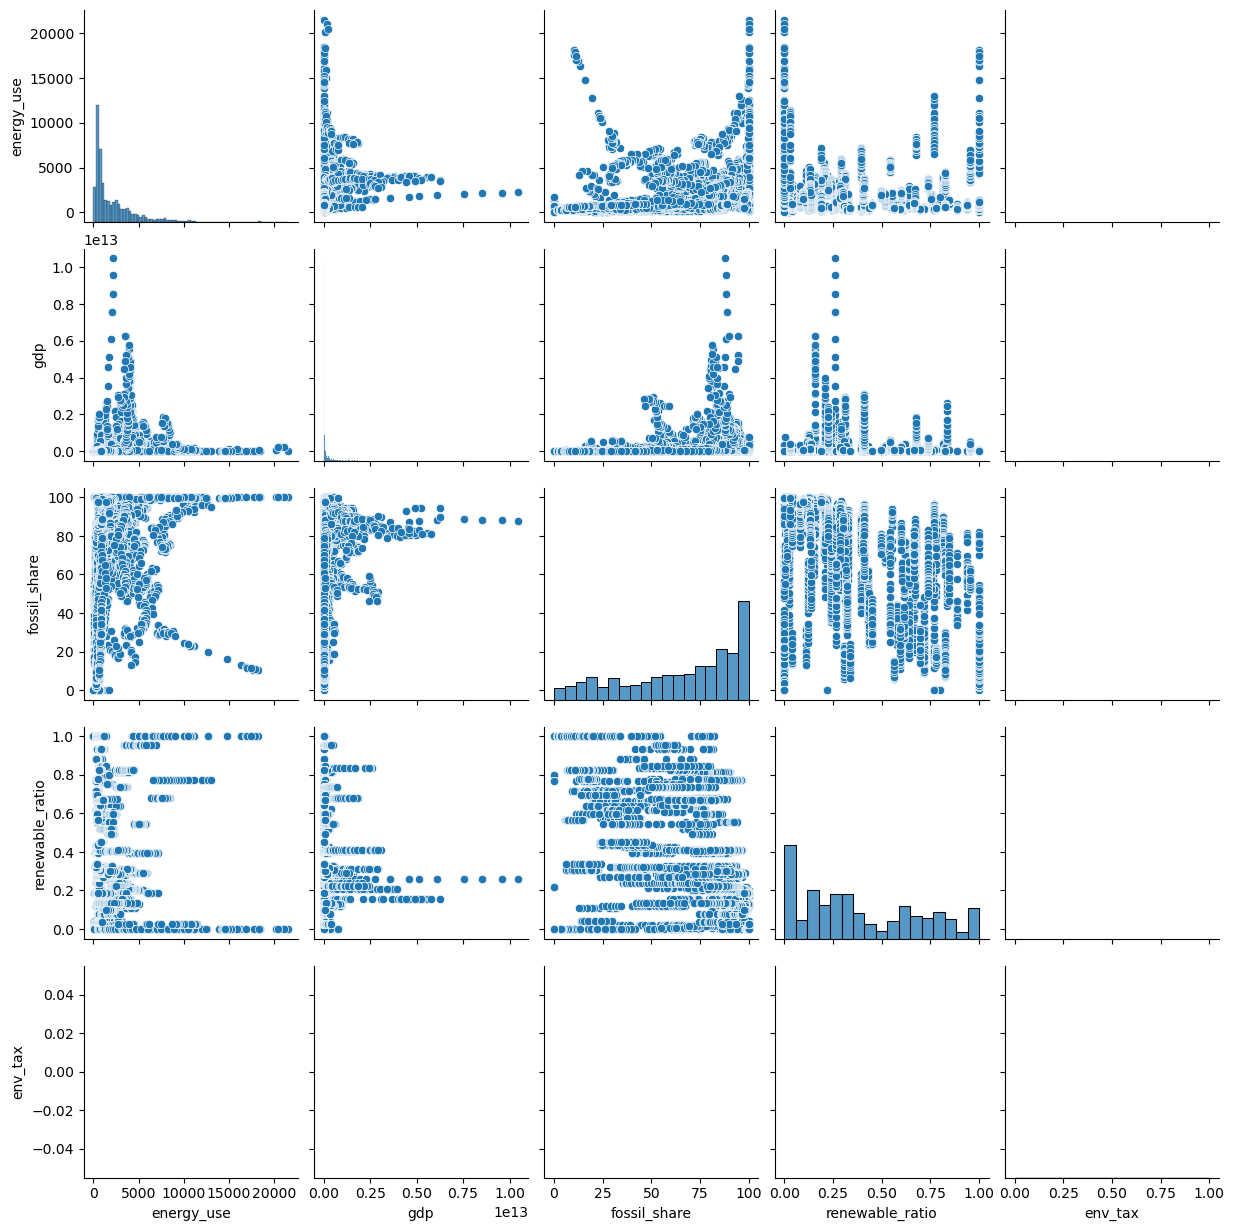

In [40]:
# -------------------------------
# Step 5: Visualizations and Diagnostics
# -------------------------------
# Reset index for plotting purposes
df_plot = df_panel_clean.reset_index()

# Plot energy use trends for selected countries:
# Example: Top 5 countries by average renewable_ratio (green leaders)
top_green = df_plot.groupby("country")["renewable_ratio"].mean().nlargest(5).index
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot[df_plot["country"].isin(top_green)], x="year", y="energy_use", hue="country")
plt.title("Energy Use Trends for Top Renewable Ratio Countries")
plt.xlabel("Year")
plt.ylabel("Energy Use (kg oil equivalent per capita)")
plt.show()

# Example: Bottom 5 countries by average renewable_ratio (fuel dominated)
top_fossil = df_plot.groupby("country")["renewable_ratio"].mean().nsmallest(5).index
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot[df_plot["country"].isin(top_fossil)], x="year", y="energy_use", hue="country")
plt.title("Energy Use Trends for Lowest Renewable Ratio Countries")
plt.xlabel("Year")
plt.ylabel("Energy Use (kg oil equivalent per capita)")
plt.show()

# Pairplot of key variables
sns.pairplot(df_plot[["energy_use", "gdp", "fossil_share", "renewable_ratio", "env_tax"]])
plt.show()

# Interactive visualization: Energy use trends across all countries
fig = px.line(df_plot, x="year", y="energy_use", color="country",
              title="Interactive Energy Use Trends Across Countries")
fig.show()

# -------------------------------
# Step 6: Advanced Analysis Summary
# -------------------------------
# The advanced analysis uses two-way fixed effects (controlling for both country and time heterogeneity)
# and incorporates a policy indicator (env_tax) alongside economic and energy mix variables.
# Robustness is checked via a Random Effects model and a Hausman test.
# The visualizations support interpretation of trends and diagnostic checks.